# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.
##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.
##### (6) 2007년과 2008년 데이터를 예측하여라

In [37]:
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2)
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

Loading required package: stats4


Attaching package: ‘sarima’


The following object is masked from ‘package:astsa’:

    sarima


Loading required package: zoo

Warning message:
“package ‘zoo’ was built under R version 4.0.5”

Attaching package: ‘zoo’


The following object is masked from ‘package:timeSeries’:

    time<-


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [38]:
z <- mcopper

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



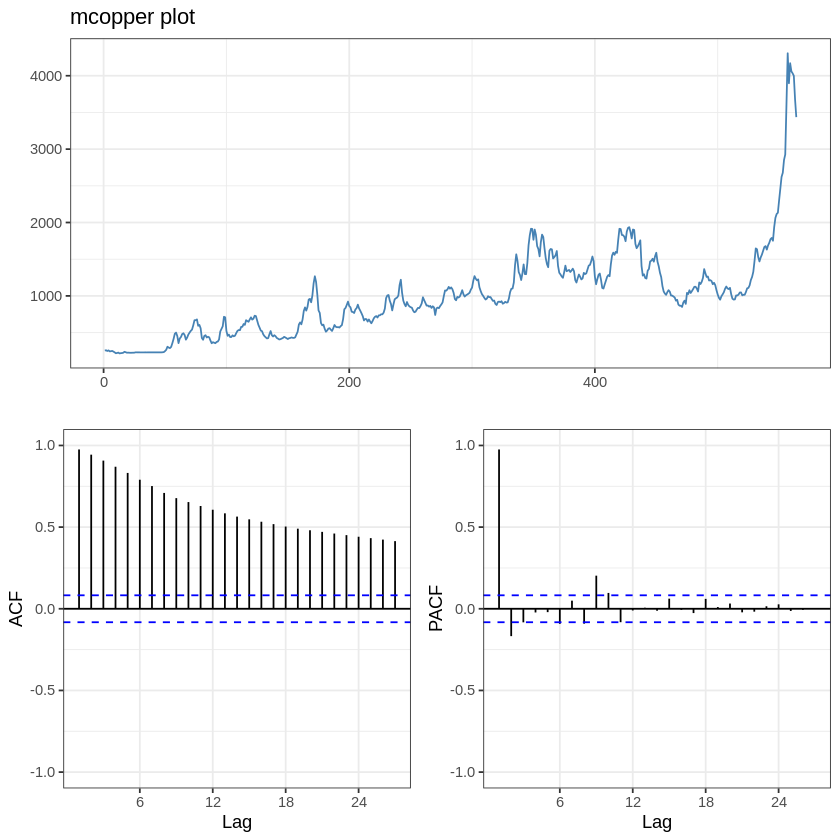

In [39]:
## 시계열그림 / ACF PACF

p3 <- ggplot(dt, aes(t, z)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('mcopper plot')+
  theme_bw()

p1 <- ggAcf(dt$z) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$z) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- ACF 그림은 지수적으로 천천히 감소하고 있는 형태를 뛰어 차분이 필요하겠다.
- PACF 그림은 1 시차에서 크게 유의하니 AR(1)모형이라 볼 수 있겠다.

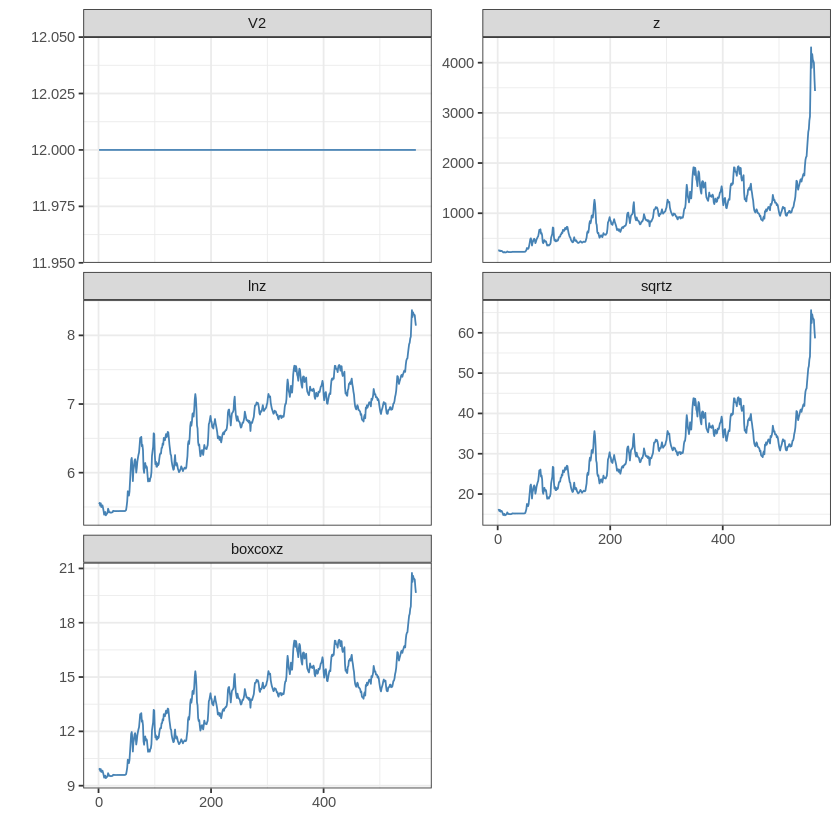

In [40]:
dt[, lnz := log(z)]
dt[, sqrtz := sqrt(z)]
dt[, boxcoxz := BoxCox(z,lambda= BoxCox.lambda(z))]
# 세 변환 비교
melt.dt <- melt(dt, id=1)
ggplot(melt.dt, aes(t, value)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ 
  facet_wrap(variable~.,nrow=3,ncol=2, scales = "free_y")+
  theme_bw()

In [42]:
bptest(lm(lnz~t, dt))
bptest(lm(sqrtz~t, dt))
bptest(lm(boxcoxz~t, dt))


	studentized Breusch-Pagan test

data:  lm(lnz ~ t, dt)
BP = 11.783, df = 1, p-value = 0.0005976



	studentized Breusch-Pagan test

data:  lm(sqrtz ~ t, dt)
BP = 87.152, df = 1, p-value < 2.2e-16



	studentized Breusch-Pagan test

data:  lm(boxcoxz ~ t, dt)
BP = 61.128, df = 1, p-value = 5.348e-15


- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 이용해볼 것이다.

- 하지만 bptest 해보니 다 이분산성 보이네..

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [53]:
auto.arima(dt$lnz)
auto.arima(dt$lnz, trace=T, ic='aic')

Series: dt$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)(1,0,1)[12] with drift         : -1544.838
 ARIMA(0,1,0)            with drift         : -1485.363
 ARIMA(1,1,0)(1,0,0)[12] with drift         : -1536.676
 ARIMA(0,1,1)(0,0,1)[12] with drift         : -1555.381
 ARIMA(0,1,0)                               : -1484.453
 ARIMA(0,1,1)            with drift         : -1556.04
 ARIMA(0,1,1)(1,0,0)[12] with drift         : -1549.529
 ARIMA(0,1,1)(1,0,1)[12] with drift         : -1547.579
 ARIMA(1,1,1)            with drift         : -1553.325
 ARIMA(0,1,2)            with drift         : -1554.063
 ARIMA(1,1,0)            with drift         : -1543.596
 ARIMA(1,1,2)            with drift         : Inf
 ARIMA(0,1,1)                               : -1556.275
 ARIMA(0,1,1)(1,0,0)[12]                    : -1549.683
 ARIMA(0,1,1)(0,0,1)[12]                    : -1555.778
 ARIMA(0,1,1)(1,0,1)[12]                    : -1547.736
 ARIMA(1,1,1)                               : -155

Series: dt$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- ARIMA(0.1.1) 모형, 즉 한 번 차분한 MA(1) 모형이 제일 적합하다는 결론이 나왔다.

In [55]:
fit = arima(dt$lnz, order = c(0,1,1))
fit


Call:
arima(x = dt$lnz, order = c(0, 1, 1))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

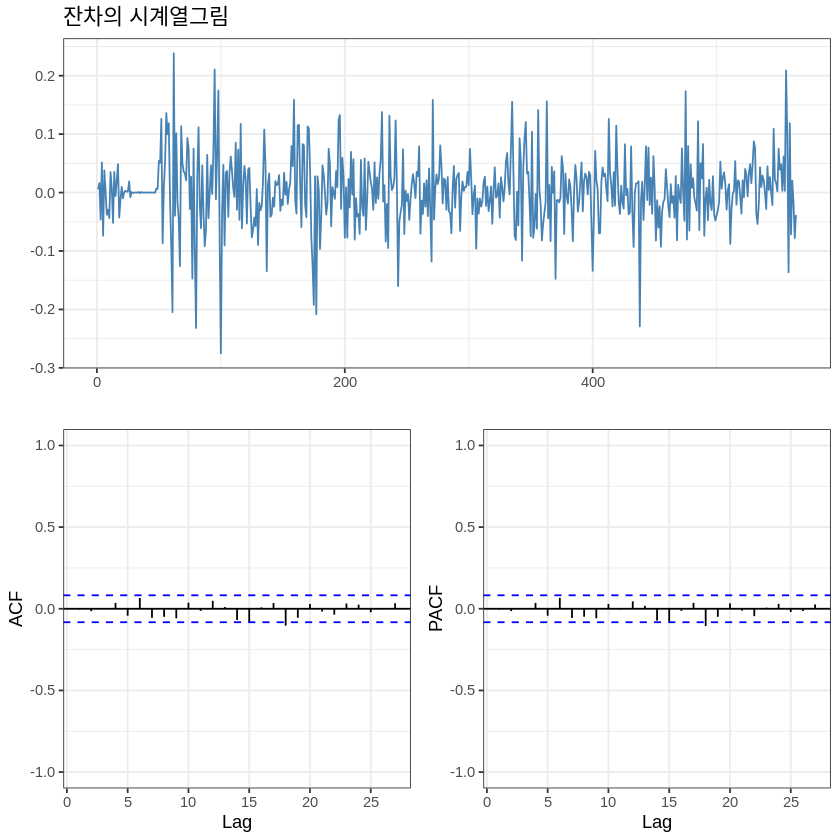

In [57]:
dt[, res := as.numeric(resid(fit))]

p3 <- ggplot(dt, aes(t, res)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+
  theme_bw()

p1 <- ggAcf(dt$res) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$res) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

,lags,statistic,df,p-value
,6,4.389073,5,0.49486084
,12,11.774747,11,0.38081082
,18,25.513977,17,0.08378234
,24,29.716259,23,0.15772145



	Shapiro-Wilk normality test

data:  dt$res
W = 0.96372, p-value = 1.406e-10


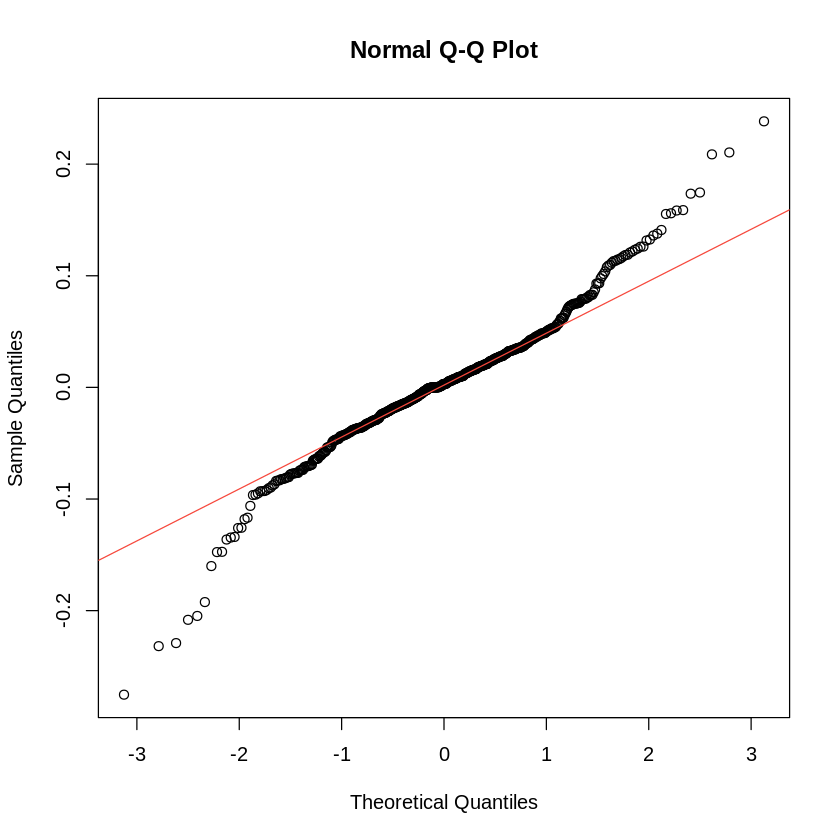

In [62]:
LjungBox(fit, lags=seq(6,24,6))# 잔차의 포트맨토검정 
shapiro.test(dt$res)  ##H0 : normal distribution
qqnorm(dt$res)
qqline(dt$res, col = 2)

- 해당 모형에 적합한 후 잔차 그림을 그려보니 ACF,PACF에서 유의한 값을 찾을 수 없었고, 잔차그림도 잘 분산되어 있는 것 같다.
- 하지만 정규성 가정을 만족하지 않았다.

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



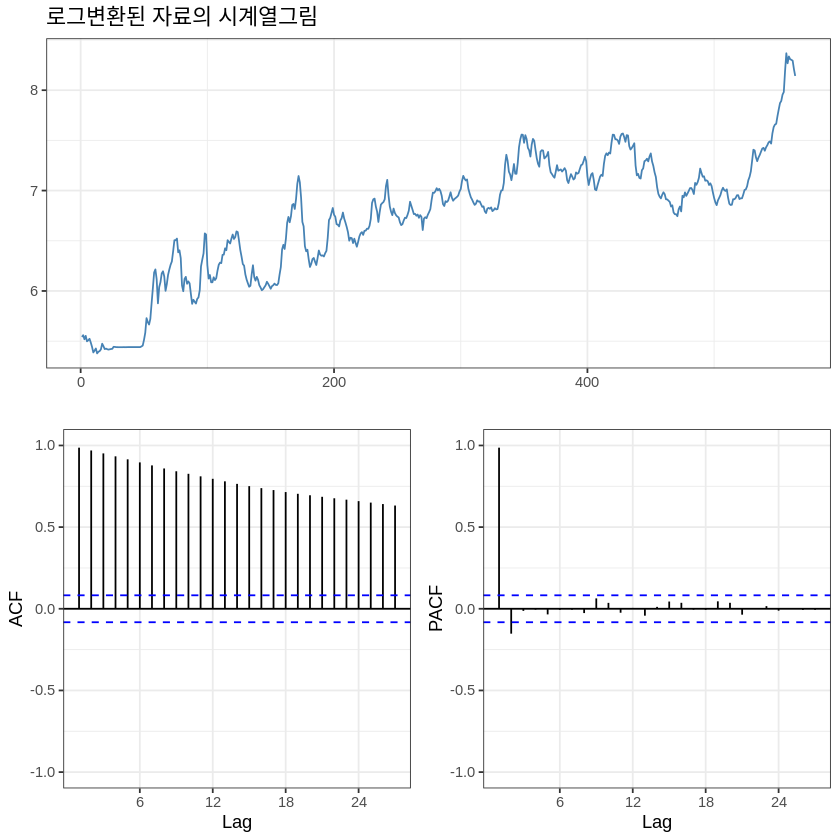

In [43]:
p3 <- ggplot(dt, aes(t, lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환된 자료의 시계열그림')+
  theme_bw()

p1 <- ggAcf(dt$lnz) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$lnz) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

- 분산 안정화 하고 보니 계절성분이 존재하는 것 같다.
- 또한 ACF 가 지수적으로 감소하는 형태를 볼 수 있었다.
- 하지만 ACF에서 계절 주기가 보이지 않아 차분은 필요없어 보인다.

In [46]:
## 단위근검정 H0 : phi=1
adfTest(dt$lnz, lags = 0, type = "c")
adfTest(dt$lnz, lags = 1, type = "c")
adfTest(dt$lnz, lags = 2, type = "c")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -0.9274
  P VALUE:
    0.7141 

Description:
 Thu Dec  9 21:21:25 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -1.5322
  P VALUE:
    0.488 

Description:
 Thu Dec  9 21:21:25 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -1.3283
  P VALUE:
    0.5642 

Description:
 Thu Dec  9 21:21:25 2021 by user: 


- 모두 귀무가설을 기각하지 못하여 단위근이 있다는 결론이 나온다.
- 단위근 있으니 차분을 해볼 것이다.

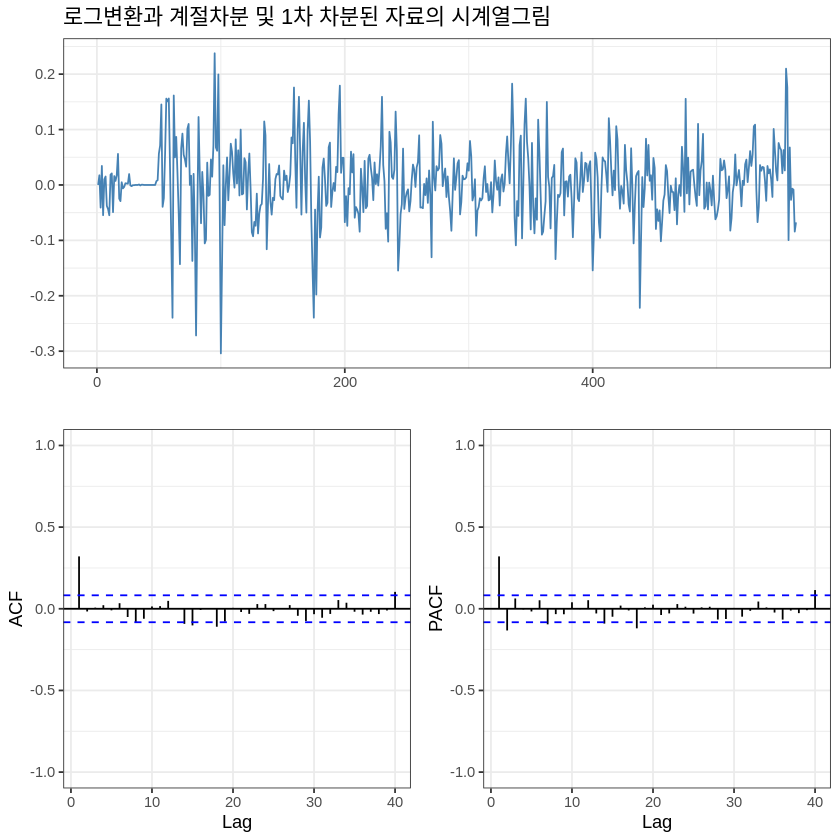

In [51]:
dt[, dt1_lnz := c(0, diff(lnz))]
dt1 <- dt[-1,]

p3 <- ggplot(dt, aes(t, dt1_lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환과 계절차분 및 1차 차분된 자료의 시계열그림')+
  theme_bw()

p1 <- ggAcf(dt$dt1_lnz, lag.max = 40) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$dt1_lnz, lag.max = 40) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

- 더이상 차분할 필요가 없겠다. 천천히 감소하거나 그런 그림이 보이지 않기 때문이다.
- ACF랑 pacf 둘 다 첫 번째 차수에서 유의한 모습이지만, PACF의 두 번째 차수는 애매하다.
- ACF를 보면 AR(1)인 것 같다.
- PACF를 보면 MA(1)이나 MA(2)인 거 같은데, MA(1)를 잠정모형으로 택해볼 것이다.

In [ ]:

하지만 잔차에 대한 검정을 했을때 문제가 없는 게 중요 그래서 앞에 거 선택하면 좋겠지?